In [1]:
#script written by Sebastian Heedt to analyze Coulomb blockade oscillations
%matplotlib inline
%load_ext autoreload

import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir)

In [2]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.mlab as ml
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.ticker as ticker
import scipy, scipy.stats, scipy.integrate
from scipy import interpolate
import coulomb_oscillations_analysis as coa
import math
pi = math.pi

def find_nearest(array, value):
    idx = (np.abs(array-value)).argmin()
    return array[idx]

kB = 1.38064852e-23
e = 1.6021766208e-19
h = 6.626070040e-34

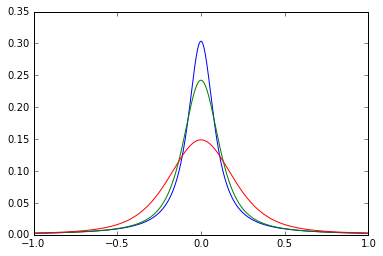

In [3]:
alpha = 0.072 #lever arm


def thermal_broadening(E, T):    
    return (1/(4.0*kB*T))*(np.cosh(E/(2.0*kB*T)))**(-2)


def Breit_Wigner(E, A, Vg, Vg_0, Gamma):
    'in units of 2e2/h'
    return 1/2/A/pi*h*Gamma/((h*Gamma/2)**2+(alpha*e*(Vg-Vg_0)-E)**2)


def CoulIntergrand(E, A, Vg, Vg_0, Gamma, T):
    'the intergrand for the Coulomb peak'
    return  thermal_broadening(E, T) * Breit_Wigner(E, A, Vg, Vg_0, Gamma) 


def G_CP(A, Vg, Vg_0, Gamma, T, offset):
    
    sampleE =  np.linspace(-10*kB*T-4*h*Gamma,10*kB*T+4*h*Gamma,10000)
    return scipy.integrate.simps(CoulIntergrand(sampleE, A, Vg, Vg_0, Gamma, T), x=sampleE) + offset


testVg = np.linspace(-0.001,0.001,500)
for t in [0.01,0.03,0.08]:
    testG = [G_CP(A=1e24, Vg=el, Vg_0=0, Gamma=3e9, T=t, offset=0) for el in testVg]
    plt.plot(testVg/1e-3,testG)


def ifitter(Vgate, Vg_0, A, Gamma, T, offset):
    #print(h*Gamma/e/1e-6, 4*kB*T/e/1e-6, Gamma/1e9, T)
    return [G_CP(A=A, Vg=el, Vg_0=Vg_0, Gamma=Gamma, T=T, offset=offset) for el in Vgate]

0.31


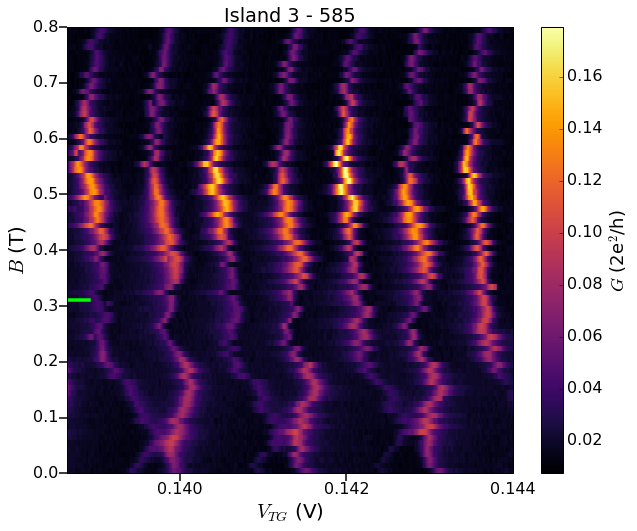

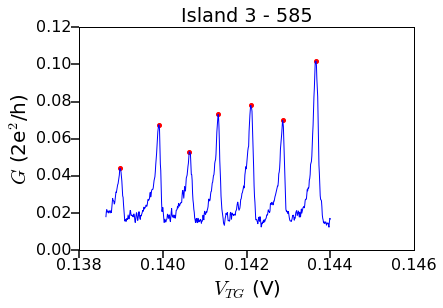

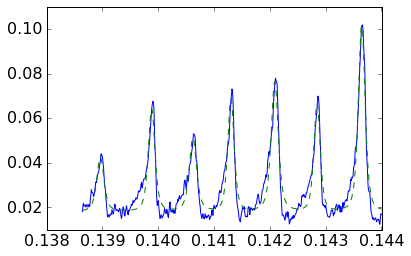

0.32


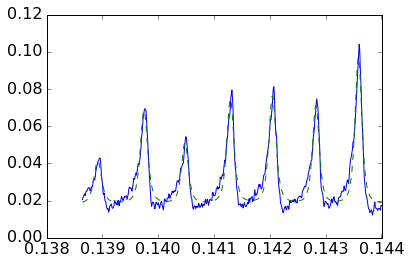

0.33


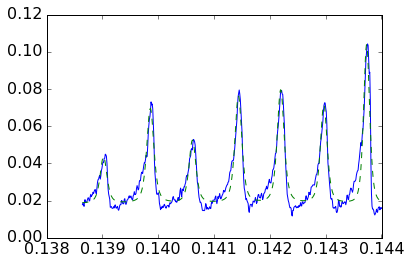

0.34


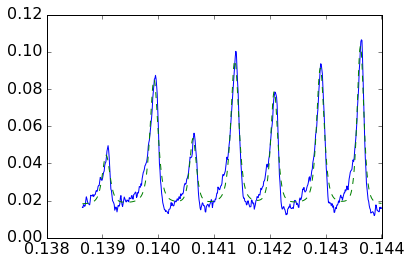

0.35


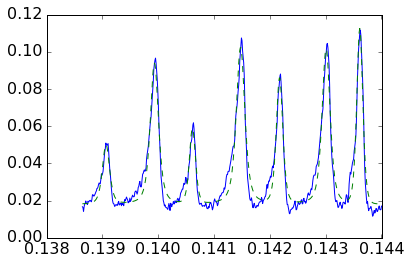

0.36


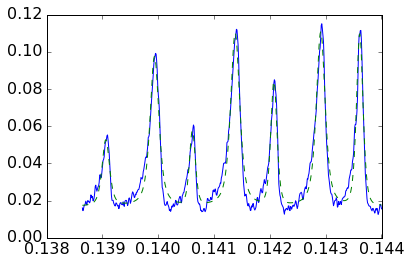

0.37


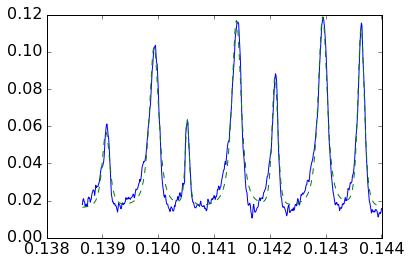

0.38


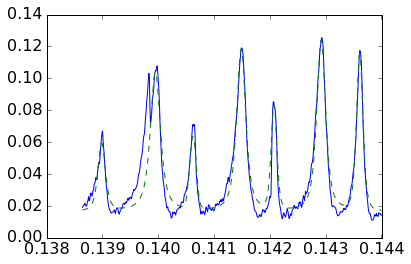

0.39


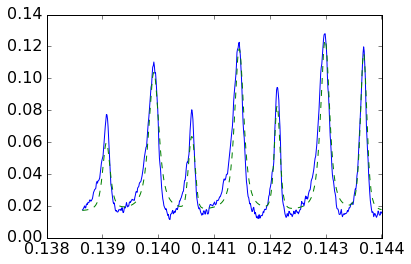

0.4


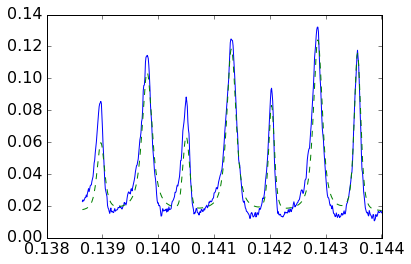

0.41


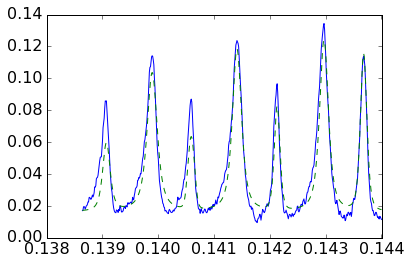

0.42


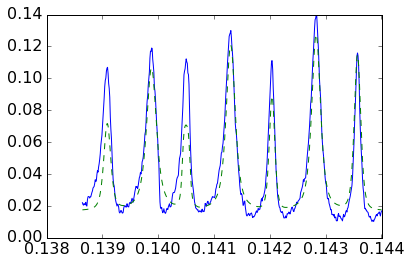

0.43


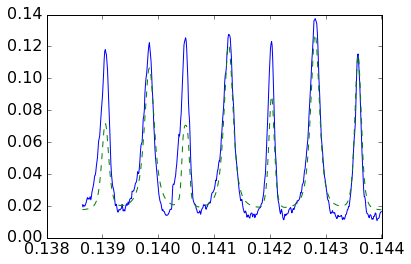

0.44


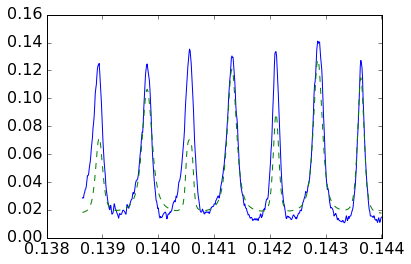

In [8]:
FileDir = 'C:\\Users\\sheedt\\Dropbox\\Majobox\\script'
fname = 'Majobox2_island3_585'
filename = os.path.join(FileDir, fname + '.dat')
df = pd.read_csv(filename, delimiter='\t', \
                 header=52, names=['V_PG', 'B', 'a', 'b', 'I', 'd', 'e', 'G', 'f', 'g', 'h', 'i', 'j', 'k'])
#print(df.head())
#print(df.tail())

df['V_PG'] = df['V_PG']/1000*0.1
datapoints_orig = 600
Vrange = 0.006
cut_left = 0.13864
cut_right = 0.144
datapoints = round(datapoints_orig*(cut_right-cut_left)/Vrange+1)
df = df[df['V_PG'] >= cut_left]
df = df[df['V_PG'] <= cut_right]

df['G'] = df['G']/1e6
Rser=2*(1350+800)+3000 # series resistance for K1
AC_exc=3.5355e-6
df['G']=h/e**2/2*df['G']/(AC_exc-df['G']*Rser)
G = []
for i in range(0, 81):
    G.append(np.array(df['G'].tolist()[i*datapoints:(i+1)*datapoints]).transpose())
G = np.array(G).transpose()
B_start = 0
B_end = 0.8
Vg_start = cut_left
Vg_end = cut_right
x_coor = np.linspace(Vg_start, Vg_end, datapoints)
y_coor = np.linspace(B_start, B_end, 81)
x, y = np.meshgrid(x_coor, y_coor)
mpl.rcParams.update({'font.size': 16})
fig, ax = plt.subplots(1, 1, figsize=(10,8))
im = ax.pcolor(x, y, G.transpose(), cmap=plt.cm.inferno)
cbar = fig.colorbar(im)
cbar.set_label('$G$ (2e$^2$/h)', fontsize = 18)
ax.set_title('Island 3 - 585')
ax.set_xlabel('$V_{TG}$ (V)', fontsize = 20)
ax.set_ylabel('$B$ (T)', fontsize = 20)
ax.set_xlim((Vg_start, Vg_end))
ax.set_ylim((B_start, B_end))
tick_spacing_x = 0.002
tick_spacing_y = 0.1

linecut = 0.31 #Field in T where line cut is taken
plt.axhline(y=linecut, xmin=0, xmax=0.05, linewidth=3.5, color = 'lime')
ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing_x))
ax.yaxis.set_major_locator(ticker.MultipleLocator(tick_spacing_y))
ax.tick_params(direction='out', length=8, width=1.5, right='off', top='off')

index = y_coor.tolist().index(find_nearest(y_coor, linecut))
fig, ax = plt.subplots(1, 1, figsize=(6,4))
ax.plot(x[0], np.array(G).transpose()[index].tolist())
ax.set_title('Island 3 - 585')
ax.set_xlabel('$V_{TG}$ (V)', fontsize = 20)
ax.set_ylabel('$G$ (2e$^2$/h)', fontsize = 20)
#ax.set_xlim((Vg_start, Vg_end))
#ax.set_ylim((0, 1.3e-4))
tick_spacing_x = 0.002
#tick_spacing_y = 5e-5
ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing_x))
#ax.yaxis.set_major_locator(ticker.MultipleLocator(tick_spacing_y))
ax.tick_params(direction='out', length=8, width=1.5, right='off', top='off')

peaks = coa.detect_peaks(G.transpose()[index].tolist(), mph=0.035, mpd=30, threshold=0, edge='both', kpsh=False, valley=False, show=False, ax=None)
listpeaks = [x[0][i] for i in peaks]
ax.scatter(listpeaks, [G.transpose()[index].tolist()[x] for x in peaks], 16, marker='o', color='r')

Vgate=x[0].tolist()
Vgates = [Vgate] * len(listpeaks)
Cond=G.transpose()[index].tolist()
cond_peaks = [Cond[i] for i in peaks]
plt.figure()

fit_single_trace = False
if fit_single_trace == True:
    A = 3.0e24
    Gamma = 1.0e7
    T = 0.030
    offset = 0.012
    guess = []
    guess += listpeaks
    guess += (np.array([A] * len(listpeaks))*max(cond_peaks)/np.array(cond_peaks)).tolist()
    guess += [Gamma] * len(listpeaks)
    guess += [T, offset]
    
    def nifitter(Vgates, *params):
        r = [0] * len(Vgates[0])
        for i,gate in enumerate(Vgates):
            r = np.array(r)+np.array(ifitter(gate, params[i], params[i+len(Vgates)], params[i+2*len(Vgates)], params[-2], params[-1]))
        r = r - (len(Vgates)-1)*params[-1]
        return r.tolist() #np.array(r).flatten()
    
    popt_list = []
    pcov_list = []
    popt = np.array(guess)
    
    popt, pcov = scipy.optimize.curve_fit(nifitter, Vgates, Cond, p0=guess, xtol = 0.000001, maxfev = 700)
    popt_list.append(popt)
    pcov_list.append(pcov)
    
    plt.plot(Vgates[0], nifitter(Vgates, *popt), 'g--')
    plt.figure()

fit_peaks = True
if fit_peaks == True:
    #Fit all Coulomb peaks using the same electron temperature:
    A = 4.0e24
    Gamma = 1.0e9
    T = 0.019
    offset = 0.010
    guess = []
    guess += listpeaks
    guess += (np.array([A] * len(listpeaks))*max(cond_peaks)/np.array(cond_peaks)).tolist()
    guess += [Gamma] * len(listpeaks)
    guess += [T, offset]
    
    def nifitter(Vgates, *params):
        r = [0] * len(Vgates[0])
        for i,gate in enumerate(Vgates):
            r = np.array(r)+np.array(ifitter(gate, params[i], params[i+len(Vgates)], params[i+2*len(Vgates)], params[-2], params[-1]))
        r = r - (len(Vgates)-1)*params[-1]
        return r.tolist() #np.array(r).flatten()
    
    popt_list = []
    pcov_list = []
    popt = np.array(guess)
    field_values = np.linspace(0.31, 0.44, 14)
    for linecut in field_values:
        print(linecut)
        index = y_coor.tolist().index(find_nearest(y_coor, linecut))
        plt.plot(x_coor, G.transpose()[index].tolist())
        peaks = coa.detect_peaks(G.transpose()[index].tolist(), mph=0.035, mpd=30, threshold=0, edge='both', kpsh=False, valley=False, show=False, ax=None)
        listpeaks = [x[0][i] for i in peaks]
        Cond=G.transpose()[index].tolist()
        cond_peaks = [Cond[i] for i in peaks]
        
        guess = []
        guess += listpeaks
        guess += popt.tolist()[len(listpeaks):]
        
        popt, pcov = scipy.optimize.curve_fit(nifitter, Vgates, Cond, p0=guess, xtol = 0.0000001, maxfev = 700)
        popt_list.append(popt)
        pcov_list.append(pcov)

    
        #h*Gamma, 4kT, Gamma/GHz, T

        plt.plot(Vgates[0], nifitter(Vgates, *popt), 'g--')
        plt.show()
        plt.figure()

In [9]:
G = []
for i,el in enumerate(popt_list):
    G.append(nifitter(Vgates, *el))

In [12]:
np.savetxt('Coulomb peak analysis Island 3 - 585_G_fit_310-380.csv', G[:-6], delimiter=',')